In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

First we need to specify a path to project directory where we will find datasets i.e `train.csv`,`test.csv`,`sample_submission.csv`

In this notebook i store path of said directory on the variable `proj_dir`  refer to the next cell to set appropriately

In [2]:
proj_dir = "../input/swahili-social-media-sentiment-analysis-data"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tqdm.notebook import tqdm

from sklearn import model_selection,metrics,preprocessing
import random

In [4]:
plt.rcParams['figure.figsize'] = [16, 10] # this needs to be set in another cell
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)

In [5]:
# simple transformers requires that df should contain a 'text' and a 'labels' column

sample = pd.read_csv(f"{proj_dir}/sample_submission.csv")

train = pd.read_csv(f"{proj_dir}/Train.csv")
test = pd.read_csv(f"{proj_dir}/Test.csv")

# i create 'labels' column directly
le = preprocessing.LabelEncoder()
train['labels'] = le.fit_transform(train.Labels)

target = 'labels'
seed = 42

In [6]:
sample.head()

,ID,Labels
0,1654,0.0
1,1597,1.0
2,1643,-1.0
3,2372,0.0
4,1577,NaN


In [7]:
train['text'] = train.Tweets.values
train.head()

,ID,Tweets,Labels,labels,text
0,2,So chuga si tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe,0,1,So chuga si tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe
1,3,Asante sana watu wa Sirari jimbo la Tarime vijijini Huu ni Upendo usio na Mashaka kwa Mbunge wenu John Heche na Chadem,1,2,Asante sana watu wa Sirari jimbo la Tarime vijijini Huu ni Upendo usio na Mashaka kwa Mbunge wenu John Heche na Chadem
2,5,Leo nimepata kitambulisho changu cha taifa Asante sana,1,2,Leo nimepata kitambulisho changu cha taifa Asante sana
3,6,Mgema akisifiwa tembo hulitia maji,0,1,Mgema akisifiwa tembo hulitia maji
4,8,Ee Mwenyezi Mungu Msamehe na Umrehemu na Umuafu na Msamehe na Mtukuze kushuka kwake kaburini na Upanue kuingia kwake na Muoshe na maji na kwa theluji na barafu na Mtakase na makosa kama Unavyoitak...,1,2,Ee Mwenyezi Mungu Msamehe na Umrehemu na Umuafu na Msamehe na Mtukuze kushuka kwake kaburini na Upanue kuingia kwake na Muoshe na maji na kwa theluji na barafu na Mtakase na makosa kama Unavyoitak...


In [8]:
test['text'] = test.Tweets.values
test.head()

,ID,Tweets,text
0,4,Maandalizi Wadau kutoka Kamati ya Maandalizi wajadili tukio kubwa la sekta hii mwaka huu Wakutana na waha,Maandalizi Wadau kutoka Kamati ya Maandalizi wajadili tukio kubwa la sekta hii mwaka huu Wakutana na waha
1,7,Tunashukuru sana kwa mrejesho wako kuhusiana na huduma zetu Tutaifikisha katika ngazi husika Karibu sana Exim Bank,Tunashukuru sana kwa mrejesho wako kuhusiana na huduma zetu Tutaifikisha katika ngazi husika Karibu sana Exim Bank
2,9,Asante kwa kutembelea kurasa yetu CM,Asante kwa kutembelea kurasa yetu CM
3,10,Habari Asante kwa kutuandikia kupitia kurasa zetu tafadhali tuandikie ujumbe na namba ya kadi kwa msaada zaidi Salim,Habari Asante kwa kutuandikia kupitia kurasa zetu tafadhali tuandikie ujumbe na namba ya kadi kwa msaada zaidi Salim
4,15,Kunawa sio wakati wa kula tutujiwekee taratibu za kunawa kila wakati,Kunawa sio wakati wa kula tutujiwekee taratibu za kunawa kila wakati


In [9]:
# Lets examine the length of texts
combo = pd.concat([train,test])
combo['strlen'] = combo.text.apply(lambda x: len(x.split(' ')))
combo['strlen'].describe()

count    3018.000000
mean       18.521206
std         8.141912
min         2.000000
25%        13.000000
50%        19.000000
75%        22.000000
max        46.000000
Name: strlen, dtype: float64

<AxesSubplot:xlabel='labels'>

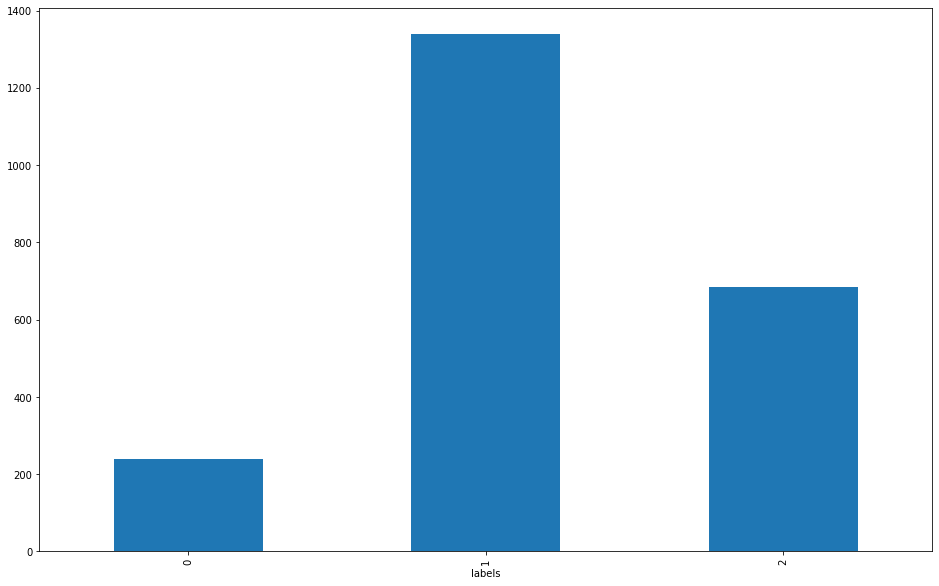

In [10]:
## lets check data imbalance
train.groupby(target)[target].count().plot(kind='bar')

Clearly we have hit data imbalance again, `stratifiedKfold` could save us!
We can also try some `class weights` and see if it helps

In [11]:
from sklearn.utils.class_weight import compute_class_weight
## lets prepare class weights
classes = list(range(train[target].nunique()))  # Free sorting
weights = list(compute_class_weight(class_weight='balanced',y=train[target],classes = classes))
cweights = dict(zip(classes, weights))
cweights

{0: 3.1562064156206415, 1: 0.5629353233830846, 2: 1.1028265107212476}

In [12]:
classes,weights

([0, 1, 2], [3.1562064156206415, 0.5629353233830846, 1.1028265107212476])

In [13]:
combo.shape

(3018, 6)

Even by normal standards, this dataset is extremely small, I mean seriously ~3000 tweets! This is big trouble already not even considering swahili is not that resourced!

Since we can use pretrained models, we have two options through translations (Note they always return top k tokens as outputs -> Juicy more data)
 - Convert to standard highly resourced and researched language a.k.a english
 - Convert each text across different languages and finally back to Swahili
 
In any case above, we'll have multiple predictions meaning much more data!

#### Data Augmentation

In [14]:
#!pip install --upgrade transformers
#!pip install tqdm==4.47.0  # see https://gitmemory.com/issue/ThilinaRajapakse/simpletransformers/919/759846471
!pip install transformers --upgrade
!pip install simpletransformers
#!pip install wandb # optional Install wandb for tracking and visualizing training in a web browser

     |████████████████████████████████| 3.5 MB 595 kB/s            
  Attempting uninstall: transformers
    Found existing installation: transformers 4.15.0
    Uninstalling transformers-4.15.0:
      Successfully uninstalled transformers-4.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.0 requires transformers<4.16,>=4.1, but you have transformers 4.16.2 which is incompatible.
     |████████████████████████████████| 248 kB 596 kB/s            
     |████████████████████████████████| 311 kB 7.0 MB/s            
     |████████████████████████████████| 9.7 MB 15.0 MB/s            
     |████████████████████████████████| 43 kB 1.7 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 243 kB 54.2 MB/s            
     |████████████████████████████████| 4.3 MB 59.3 MB/s            
     |███████████

In [15]:
import torch

In [16]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
seed_all(seed)

##### EasyNMT & m2m_100_1.2B or m2m_100_418M
This package provides easy to use, state-of-the-art machine translation for more than 100+ languages

<a href='https://github.com/UKPLab/EasyNMT'> Reference </a>

In [17]:
!pip install -U easynmt

  Preparing metadata (setup.py) ... - done
  Created wheel for easynmt: filename=EasyNMT-2.0.1-py3-none-any.whl size=15446 sha256=c15a6405a74a6992cb2e8efcc9033a4781cfe30d5bc7a57c6bbcb96f54989dfa
  Stored in directory: /root/.cache/pip/wheels/fb/42/fb/b7711d3296456d5f74e6e265dbdb0e3142158f1bb50382caef
Successfully built easynmt


In [18]:
from easynmt import EasyNMT
model = EasyNMT('m2m_100_1.2B')   #or: EasyNMT('m2m_100_1.2B or m2m_100_418M') 

89.9kB [00:00, 40.3MB/s]                   


Downloading:   0%|          | 0.00/909 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.62G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/271 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.54M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

In [19]:
lst = train['Tweets'].values
chunk_size = 8
n_chunks = len(lst)//chunk_size
chunks = np.array_split(lst, n_chunks)

outputs = []
for chunk in tqdm(chunks):
    input_texts = chunk
    output = model.translate(documents=input_texts,
                             target_lang='en',source_lang='sw',show_progress_bar=False)
    outputs += output

train['m2mEn'] = outputs    

  0%|          | 0/282 [00:00<?, ?it/s]

In [20]:
lst = test['Tweets'].values
chunk_size = 8
n_chunks = len(lst)//chunk_size
chunks = np.array_split(lst, n_chunks)

outputs = []
for chunk in tqdm(chunks):
    input_texts = chunk
    output = model.translate(documents=input_texts,
                             target_lang='en',source_lang='sw',show_progress_bar=False)
    outputs += output
    
test['m2mEn'] = outputs

  0%|          | 0/94 [00:00<?, ?it/s]

In [21]:
for index, row in train.head().iterrows():
    print(f'Original: {row.Tweets} \n')
    print(f'English: {row.m2mEn} \n')
    print('\n')

Original: So chuga si tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe 

English: Tomorrow we’ll meet at the festival, we’ll meet at the festival, we’ll meet at the festival. 



Original:    Asante sana watu wa Sirari jimbo la Tarime vijijini Huu ni Upendo usio na Mashaka kwa Mbunge wenu John Heche na Chadem 

English:    Thank you very much Sirari state of Tarime This is an unquestionable love for your member John Heche and Chadem 



Original:    Leo nimepata kitambulisho changu cha taifa Asante sana 

English:    Today I got my national identity. 



Original:    Mgema akisifiwa tembo hulitia maji 

English:    The elephant swallowed water 



Original: Ee Mwenyezi Mungu Msamehe na Umrehemu na Umuafu na Msamehe na Mtukuze kushuka kwake kaburini na Upanue kuingia kwake na Muoshe na maji na kwa theluji na barafu na Mtakase na makosa kama Unavyoitakasa nguo nyeupe kutokana na uchafu na Mbadilishie nyumba bora kuliko 

English: O All

In [22]:
# We need to chose what we'll use as english tweets
train['enTweets'] = train.m2mEn.values
test['enTweets'] = test.m2mEn.values

#### Catboost Modelling 

I think using the model as above caused use to run into curse of dimensionality! I couldn't get it give significant score, it just ended up overfitting!

In [23]:
train.head(2)

,ID,Tweets,Labels,labels,text,m2mEn,enTweets
0,2,So chuga si tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe,0,1,So chuga si tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe,"Tomorrow we’ll meet at the festival, we’ll meet at the festival, we’ll meet at the festival.","Tomorrow we’ll meet at the festival, we’ll meet at the festival, we’ll meet at the festival."
1,3,Asante sana watu wa Sirari jimbo la Tarime vijijini Huu ni Upendo usio na Mashaka kwa Mbunge wenu John Heche na Chadem,1,2,Asante sana watu wa Sirari jimbo la Tarime vijijini Huu ni Upendo usio na Mashaka kwa Mbunge wenu John Heche na Chadem,Thank you very much Sirari state of Tarime This is an unquestionable love for your member John Heche and Chadem,Thank you very much Sirari state of Tarime This is an unquestionable love for your member John Heche and Chadem


In [24]:
# make text column the translated 
#train.text = train.swc_en.values
#test.text = test.swc_en.values

#train.head(2)

In [25]:
import string, re

train['char_count'] = train.Tweets.apply(len)
train['word_count'] = train.Tweets.apply(lambda x: len(x.split()))
train['word_density'] = train.char_count / (train.word_count +1)
train['punctuation_count'] = train.Tweets.apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train['title_word_count'] = train.Tweets.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train['upper_case_word_count'] = train.Tweets.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


test['char_count'] = test.Tweets.apply(len)
test['word_count'] = test.Tweets.apply(lambda x: len(x.split()))
test['word_density'] = test.char_count / (test.word_count +1)
test['punctuation_count'] = test.Tweets.apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
test['title_word_count'] = test.Tweets.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
test['upper_case_word_count'] = test.Tweets.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

nlp_features = ['char_count','word_count','word_density',
                'punctuation_count','title_word_count','upper_case_word_count']

#### Catboost modelling

In [26]:
!pip install -q --upgrade catboost 
import catboost as cb

In [27]:
numericals = ['word_count','word_density','punctuation_count','title_word_count','upper_case_word_count'] 
texticals = ['enTweets']
categoricals = []

use_features = numericals + texticals + categoricals
use_features

['word_count',
 'word_density',
 'punctuation_count',
 'title_word_count',
 'upper_case_word_count',
 'enTweets']

In [28]:
# so lets kick of this notebook by using caboost directly and exploit text features cap
n_folds = 5
stkfold = model_selection.StratifiedKFold(n_splits= n_folds, shuffle=True,random_state=seed)

splits = list(stkfold.split(train, train.Labels))

parameters = {
        'iterations': 1500, # 5000 worked a charm
        #'leaf_estimation_iterations': 5, 
        'learning_rate': 0.3,
        'eval_metric':'Accuracy',
        #'auto_class_weights':'Balanced'
        }


model = cb.CatBoostClassifier(task_type= 'CPU',loss_function='MultiClass',
                              text_features=texticals,random_seed=seed,
                              early_stopping_rounds=100,**parameters)

for i,(train_index,test_index) in enumerate(splits):
    x_train,x_test = train.loc[train_index,use_features],train.loc[test_index,use_features]
    y_train,y_test = train.loc[train_index,'Labels'],train.loc[test_index,'Labels']
    # fit model
    model.fit(x_train, y_train,use_best_model=True,
              eval_set=(x_test,y_test),verbose= 50)
        
    x_test_preds_prob = model.predict_proba(x_test)
    x_test_preds = model.predict(x_test)
    
    # Measure our metric
    score = metrics.accuracy_score(y_true=y_test, y_pred=x_test_preds)
    print(f"Fold {i} Accuracy: {score} \n")
    
    mark_classes = [f't1 {x}' for x in model.classes_]
    classes = model.classes_
    # record OOF predictions
    train.loc[test_index,mark_classes] = x_test_preds_prob
    
    # Collect the fold predictions for later averaging
    probcols = [f'{each} {i}' for each in classes]
    
    predictions = model.predict_proba(test[use_features])
    test.loc[:,probcols] = predictions

0:	learn: 0.5933702	test: 0.5783664	best: 0.5783664 (0)	total: 549ms	remaining: 13m 42s
50:	learn: 0.6596685	test: 0.6114790	best: 0.6181015 (47)	total: 26.4s	remaining: 12m 29s
100:	learn: 0.7193370	test: 0.6158940	best: 0.6225166 (56)	total: 52.3s	remaining: 12m 3s
150:	learn: 0.7624309	test: 0.6291391	best: 0.6357616 (141)	total: 1m 18s	remaining: 11m 37s
200:	learn: 0.7861878	test: 0.6203091	best: 0.6357616 (141)	total: 1m 43s	remaining: 11m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6357615894
bestIteration = 141

Shrink model to first 142 iterations.
Fold 0 Accuracy: 0.6357615894039735 

0:	learn: 0.5955801	test: 0.5916115	best: 0.5916115 (0)	total: 459ms	remaining: 11m 27s
50:	learn: 0.6513812	test: 0.6026490	best: 0.6070640 (49)	total: 25s	remaining: 11m 51s
100:	learn: 0.7160221	test: 0.6070640	best: 0.6070640 (49)	total: 49.3s	remaining: 11m 22s
150:	learn: 0.7480663	test: 0.6092715	best: 0.6181015 (110)	total: 1m 14s	remaining: 11m 2s
200:	learn:

In [29]:
train['prediction'] = train[mark_classes].idxmax(axis='columns').str.replace('t1 ','').astype(int)
final_score = metrics.accuracy_score(y_true=train.Labels,y_pred=train['prediction'])
print(f'Accuracy score: {final_score}')

Accuracy score: 0.6164383561643836


In [30]:
for each in classes:
    foldcols = [f'{each} {x}' for x in range(n_folds)]
    test[f't1 {each}'] = test[foldcols].mean(axis='columns') # mean probability

test['Labels'] = test[mark_classes].idxmax(axis='columns').str.replace('t1 ','').astype(int)

submission = pd.DataFrame({'ID':test.ID,'Labels':test.Labels})
submission.to_csv('finalSubmission.csv',index=False)
submission.head()

,ID,Labels
0,4,0
1,7,1
2,9,1
3,10,1
4,15,0
